In [1]:
#from IPython.core.display import HTML
#def css_styling():
#    styles = open("../styles/custom.css", "r").read()
#    return HTML(styles)
#css_styling()

<figure>
<IMG SRC="images/PhysicsLogo.jpg" WIDTH=100 ALIGN=right>
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 3: Time Series and quantifying their statistics


<figure>
<IMG SRC="http://vibration.desy.de/sites2009/site_ground-vibrations/content/e1548/SpectrumComparison.jpg" WIDTH=320 ALIGN="right" STYLE="padding-left:20px" ALT="Ground motion measurements at CERN.  http://ground-vibrations.desy.de">
</figure>

As we saw in the [Introduction](Lecture-00-Intro-Python.ipynb), it possible to have two time series that have completely different character, but the same univariate statistics.  i.e. their underlying probability distribution densities can be exactly the same, but the ordering of the data matters.  

Here we define the meaning of a **Stationary Time Series** and discuss two of the most straight forward ways of characterizing the relation of that time series in time, the **Lag Covariance** and the **Spectral Density**.

 

## Time Series

### Motivating Example

Its helpful to have a simple example to think about as we go through this material.  Here we will consider the sum of two sine waves with Normally distributed noise on top of it:

\begin{equation}
    x = A_1\cos \left(\omega_1 t+\phi_1\right)+A_2\cos \left(\omega_2 t+\phi_2\right) + n(t)
\end{equation}

<IPython.core.display.Javascript object>


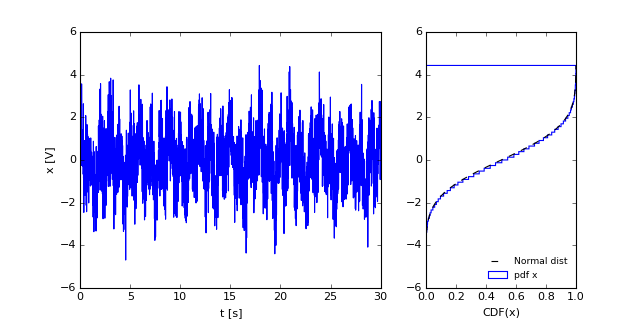

-0.00887741039774
1.74046633364


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib nbagg

# first sine wave
t = np.arange(0.,30.,0.01)
A1 = 1.;  om1 = 2.*np.pi/1.;  ph1=0.
x1 = A1*np.cos(om1*t+ph1)

# second sine wave
A2 = 0.7;   om2 = 2.*np.pi/3.;   ph2=0.3
x2 = A2*np.cos(om2*t+ph2)
# Noise
n=1.*np.random.randn(len(t))

x=x1+x2+n
fig=plt.figure(figsize=(8,4))
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

ax=fig.add_subplot(gs[0])
ax.plot(t,x)
ax.set_xlabel('t [s]');ax.set_ylabel('x [V]');
ax=fig.add_subplot(gs[1])

n,bins,pa=ax.hist(x,70,orientation='horizontal',histtype='step',cumulative=True,normed='True',label='pdf x')
norm = stats.norm.cdf(bins,loc=np.mean(x),scale=np.std(x))
ax.plot(norm,bins,'k--',label='Normal dist')
ax.set_xlabel('CDF(x)');
ax.legend(fontsize='small',loc=4,frameon=False)
print np.mean(x)
print np.var(x)

Hopefully it is clear that none of the techniques we have discussed so far will reveal the presence of the two sine waves embedded in the data. In fact the cumulative distribution of this data looks a lot like the normal distribution (plotted in a dashed line in right-hand panel). The mean and the standard deviation of a time series are often very useful to know, but we would be missing a lot of the story if we stopped there.  

If we had a good model that would indicate two sine waves, we could easily do a non-linear fit for the waves.  Note that this would entail fitting six parameters ($A_1,\omega_1,\phi_1,A_2,\omega_2,\phi_2$), which is not too hard, but what if there were three sine waves (etc)?

Rather it would be preferable to characterize this time series without any *a-priori* knowledge or hypothesized model.  With that in mind, lets consider the definition of a time-series, and one simple method to characterize their temporal information, the lagged correlation.

### Defn: Stochastic Processes

The formal definition of a **stochastic process** or a **random process** is analagous to the definition of a random variable.  A realization of a random variable $\{x\}$ is a *sample* from the probability density function $p(x)$.  A realization of a stochastic process is a *sample* time series $x_k(t)$ from a random process $\{x(t)\}$ that is continuous in time, and can be characterized by a probability structure $p\left(x(t)\right)$ that is common to all realizations.  

So, think about the temperature time-series at Deep Cove.  You have a discrete and finite realization of that time series.  Formally, to get another realization of that time series, you would need to have an alternate universe, obeying all the same laws, but with slightly different initial conditions that caused the fluctuations at Deep Cove to have the same statistical character, but have a different actual time series.  

A concrete example that does not rely on an alternate universe is to think about two equal and fair dice being rolled and the result being averaged with the previous result.  Suppose the dice is rolled at distrete times $t(i)$, then suppose we weight the current roll by $0.25$ and the previous signal by $0.75$, then:

\begin{equation}
    x(t_n)=0.75\ x(t_{n-1}) + 0.25\ r(t_n)
\end{equation}

where $r(t_n)$ is the roll, and equally likely to be $-2.5,-1.5,-0.5,0.5,1.5,2.5$.  Different realizations of this process would look different, but they would all have the same statistical character.  So here are two realizations:

<IPython.core.display.Javascript object>


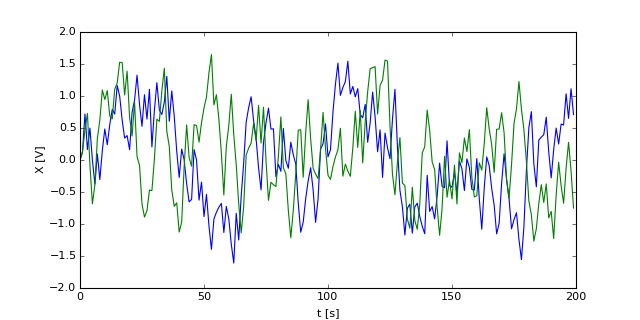

In [7]:
Nt = 200
x1=np.zeros(Nt)
x2=np.zeros(Nt)
for i in range(1,Nt):
    x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)
    x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [s]');ax.set_ylabel('X [V]')

All the momments from univariate statistics can be computed, but now they are time series.  i.e. the mean

\begin{equation}
  \mu_x(t)=E (x(t))
\end{equation}

Note that $\mu_x(t)$ is a time series and can theoretically evolve in time.  Imagine the process above, but with a steady trend added to both of the variables:

<IPython.core.display.Javascript object>


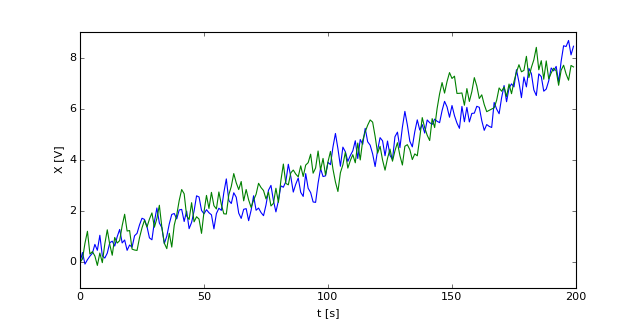

In [9]:
Nt = 200
x1=np.zeros(Nt)
x2=np.zeros(Nt)
for i in range(1,Nt):
    x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/100. # i/100 is the trend
    x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/100.
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [s]');ax.set_ylabel('X [V]')

Here, it is easy to see that the mean of the time series increases with time.  Similarly we can concoct a stochastic process for which the variance $\sigma_x^2(t)=E\left(\left(x(t)-\mu_x(t)\right)^2\right)$ increases in time:

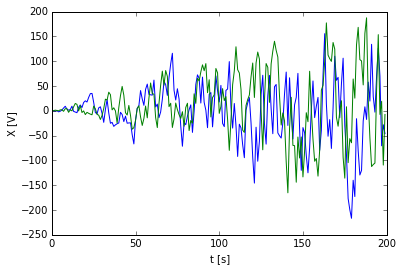

In [71]:
Nt = 200
x1=np.zeros(Nt)
x2=np.zeros(Nt)
for i in range(1,Nt):
    x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)*i
    x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)*i
fig,ax=plt.subplots(1,1)
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [s]');ax.set_ylabel('X [V]')

## Lag Covariance 

There are a number of ways to characterize time series.  First, the momments for univariate statistics can be used, where the mean, variance, skewness, etc are all time series.  i.e. for variance.

\begin{equation}
    \sigma_{x}^2(t) = \int_{-\infty}^{\infty} p(x,t) (x(t)-\mu_x(t))^2\ \mathrm{d}x
\end{equation}

However, this does not tell us anything about the relatedness of the time series in time.  In our original example, the time series had memory of the previous times and it is necessary to have a statistic that reflects this.  The lowest order statistic is the **lag auto-covariance** for comparing $x$ with itself and the **lag covariance** for comparing $x(t)$ with $y(t)$:

\begin{align}
    C_{xx}(t,t+\tau) &= E\left[\left( x_k(t)-\mu_x(t) \right)\left( x_k(t+\tau)-\mu_x(t+\tau) \right) \right]\\
    C_{xy}(t,t+\tau) &= E\left[\left( x_k(t)-\mu_x(t) \right)\left( y_k(t+\tau)-\mu_y(t+\tau) \right) \right]
\end{align}

Here $\tau$ is the "lag".  We are comparing the time series $x(t)$ with the time series $x(t+\tau)$, which is the same time series, just shifted in time by $\tau$.  

Note that for $\tau=0$, $C_{xx}(t)=\sigma_x^2(t)$, i.e. is just the variance.  

It is possible to look at three- or four-point statistics as well, though that is not commonly done, and is hard to interpret.

### Stationary Processes

A process is said to be **Weakly Stationary** if the mean $\mu_x(t)$, and the second-order *lag covariance* $C_{xx}(t,t+\tau)$ are independent of time $t$.  So, in the synthesized time series above, the linearly increasing mean and increasing variance examples are *not* stationary processes.  The original process, however, is.  

A process is said to be **Strongly Stationary** if any possible probability distributions are independent of $t$.  Again, this is rarely tested, and since the higher-order probability distributions are rarely computed, is only of academic value.

There is another special type of *weakly stationary* processes: **ergodic** processes, in which the statistics can be approximated by a subsample of the time series.  As scientists, this is what we want.  We usually do not know the underlying statistics, and we cannot collect an infinite time series to determine them, nor can we collect an infinite number of realizations. So we hope that time averaging will allow us to *estimate* the statistical momments.  Formally a process is **ergodic** if

\begin{align}
    \mu_x(k) &= \lim_{T\to\infty} \frac{1}{T}\int_0^T x(t)\ \mathrm{d}t\\
    C_{xx}(\tau,k) &= \lim_{T\to\infty}  \frac{1}{T}\int_0^T \left( x_k(t)-\mu_x(t) \right)\left( x_k(t+\tau)-\mu_x(t+\tau) \right)\ \mathrm{d}t\\
\end{align}

Practically, its  hard to find a time series that is truly ergodic.  There are various approaches around this

  1. We can ignore the lack of ergodicity, or assume it doesn't affect our results too much (bad idea, but sometimes done!)
  2. We can divide the time series into reasonably ergodic regions
  3. We can massage the data to make it more ergodic.
  
i.e. in the case above where the mean was linearly increasing, we might have removed the long-term trend by a linear fit with time and considered just the deviations from the linear fit:

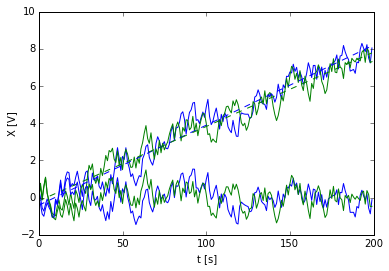

In [72]:
Nt = 200
x1=np.zeros(Nt)
x2=np.zeros(Nt)
t = arange(Nt)
for i in range(1,Nt):
    x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/100.
    x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/100.
fig,ax=plt.subplots(1,1)
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [s]');ax.set_ylabel('X [V]')
# linear fit:
from scipy import polyfit 
ar,br=polyfit(t,x1,1);xf1=br+ar*t
ar,br=polyfit(t,x2,1);xf2=br+ar*t
# plot the fits
plot(xf1,'b--');plot(xf2,'g--')
# plot the ts with the linear trend removed...
plot(x1-xf1,'b');plot(x2-xf2,'g')

Here we would argue that the de-trended time series is more ergodic than the original.  

Similarly, if a signal changes its variance suddenly at some point of the time series, it would make sense to analyze the two sections separately.  For real data this all has some artistic aspect to it, and the decisions you make should be shown to not strongly affect your results, or at least the effect quantified in some way.  

### Ex: Lag-covariance

So we can compare the lag covariance for different signals.  We showed above that our weighted-average dice roll had a mean of zero and a standard deviation of 0.61.  Lets compare the lag covariance of our signal to a random Normal distributed process.

<IPython.core.display.Javascript object>


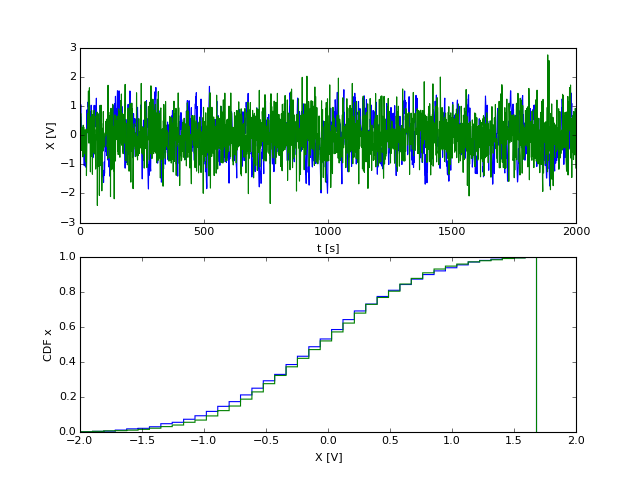

In [16]:
Nt = 2000
x1=np.zeros(Nt)
x2=np.zeros(Nt)
t = np.arange(Nt)
# x1 is the weighted average of the previous rolls (as above)
for i in range(1,Nt):
    x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)
# x2 is a random process with the same standard deviation as x1:
x2=np.random.randn(Nt)*np.std(x1)  

fig,axs=plt.subplots(2,1)
ax=axs[0]
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [s]');ax.set_ylabel('X [V]')
ax=axs[1]
(n,bins,pa)=ax.hist(x1,bins=40,cumulative=True,histtype='step',normed=True);
ax.hist(x2,bins=bins,cumulative=True,histtype='step',normed=True);
ax.set_xlabel('X [V]');ax.set_ylabel('CDF x')

Here we did the example for a longer time so the lag statistics are robust. Note that the PDFs of the two processes are almost exactly the same.  So, now we do the finite version of the integrals above:

<IPython.core.display.Javascript object>


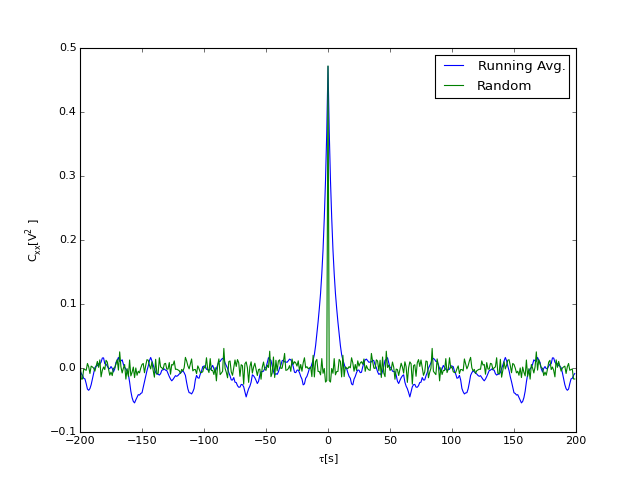

In [19]:
lags = range(-200,200) # the lags are integers
cxx1=0.*np.array(lags);cxx2=0.*np.array(lags)
# note that mean(x1)=mean(x2)=0
# tau is the lag.  
for ind,tau in enumerate(lags):
    if tau<0:
        cxx1[ind]=np.mean(x1[:tau]*x1[-tau:])
        cxx2[ind]=np.mean(x2[:tau]*x2[-tau:])
    elif tau==0:
        cxx1[ind]=np.mean(x1*x1)
        cxx2[ind]=np.mean(x2*x2)
    else:
        cxx1[ind]=np.mean(x1[:-tau]*x1[tau:])
        cxx2[ind]=np.mean(x2[:-tau]*x2[tau:])
fig,ax=plt.subplots(1,1,)
ax.plot(lags,cxx1,label='Running Avg.')
ax.plot(lags,cxx2,label='Random')
ax.set_xlabel(r'$\tau [s]$')
ax.set_ylabel('$C_{xx} [V^2]$')
ax.legend()


So, here we can see the structure of the running average signal (blue) compared to the completely random uncorrelated signal.  Of course the un-correlated signal has variance, so $C_{xx}>0$ at lag $\tau=0\ s$, but for other lags, it is just noise (ahem, which we will discuss later).  The auto-covariance of the running average signal shows positive lag covariance up to lags of 12 s or so, though perhaps only significantly to 8 s.  This covariance is a result of averaging our current dice roll with the previous rolls.  If we increased the averaging, we might expect the covariance to remain positive for larger lags.  

### Useful relations

The **lag correlation** is the same as the **lag covariance** except without the means removed.  So

\begin{align}
    R_{xx}(\tau) = E\left[x(t)x(t+\tau) \right]\\
    R_{xy}(\tau) = E\left[x(t)y(t+\tau) \right]
\end{align}

If a process is *stationary* then the *lag correlation is symmetric*:

\begin{align}
    R_{xx}(\tau) &= R_{xx}(-\tau)\\
    R_{xy}(\tau) &=R_{yx}(-\tau)
\end{align}

**Proof** simply note that 

\begin{align}
    R_{xx}(-\tau) &= E\left[x(t)x(t-\tau) \right]\\
                   &=E\left[x(t'+\tau)x(t') \right]\  \ \ \mathrm{if\ we\ define\ } t'=t-\tau\\
                   &= R_{xx}(\tau)
\end{align}

if the process is stationary.  Note that for $R_{xy}$ the order of $x$ and $y$ matter.  

If a process is stationary, we can also argue that the magnitude of the cross correlation is bounded by the lag correlations of the individual processes:

\begin{equation}
    \left|R_{xy}(\tau) \right|^2 \leq R_{xx}(0)\ R_{yy}(0)
\end{equation}

**Proof** The proof of this uses a fun trick.  Consider for any constant $a$:

\begin{align}
    E \left[ \left( x(t)+a y(t+\tau) \right)^2 \right] & \geq 0\\
    E \left[ x(t)^2 \right] +2a E \left[ x(t)\,y(t+\tau)\right]  + a^2 E \left[ y(t)^2 \right]& \geq 0\\
    R_{xx}\left(0\right) + 2 a R_{xy}(\tau) +a^2 R_{yy}(0) & \geq 0
\end{align}

Note that this is a quadratic in $a$, and we are saying that it is always greter than zero.  That means it has no real roots, which from the quadratic formula means that $4 R_{xy}(\tau)^2 - 4 R_{yy}(0) R_{xx}\left(0\right)\leq 0$, or 

\begin{equation}
    \left|R_{xy}(\tau) \right|^2 \leq R_{xx}(0)\ R_{yy}(0)
\end{equation}

Similarly for the *lag covariance*:

\begin{equation}
    \left|C_{xy}(\tau) \right|^2 \leq C_{xx}(0)\ C_{yy}(0)
\end{equation}

which allows us to define the **lag correlation co-efficient**

\begin{equation}
    \rho_{xy}(\tau) = \frac{C_{xy}(\tau)}{\sigma_x\sigma_y}
\end{equation}

and note that $\left|\rho_{xy}(\tau) \leq 1\right|$.  This is likely the more useful quantity than $C_{xy}$, and is usually what is plotted.   From the example above, we note that $\rho_{xx}(0)=1$:

<IPython.core.display.Javascript object>


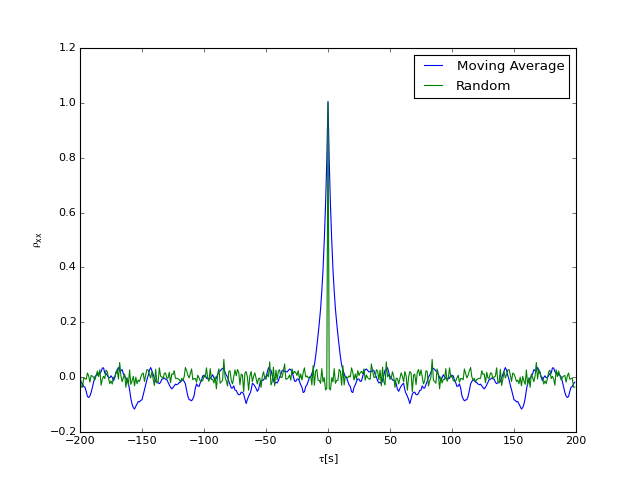

In [20]:
fig,ax=plt.subplots(1,1)
ax.plot(lags,cxx1/np.var(x1),label='Moving Average')
ax.plot(lags,cxx2/np.var(x2),label='Random')
ax.legend(loc=0)
ax.set_xlabel(r'$\tau [s]$')
ax.set_ylabel(r'$\rho_{xx}$')

### Ex: Common Processes and their auto-correlations

**Constant in time:** If $x(t)=c$, then the lag auto-correlation is simply $R_{xx}(\tau) = c^2$.  Note that the auto-covariance is $C_{xx}(\tau)=0$.

**Sine wave:** If $x(t)= X \cos(2\pi f+\phi_k)$, where $\phi_k$ is a random phase, then the lag auto-correlation and auto-covariance are $R_{xx}(\tau) = \frac{X^2}{2}\cos\left(2\pi f \tau \right)$

**White Noise:** For a discrete system, white noise can be approximated by a string of uncorrelated random draws from the Normal distribution.  For a continuous system, it is theoretically undefined, though it can be approached.  If we do that, then $\lim_{N\to\infty}R_{xx}(\tau)=\delta(\tau).$  We saw this in the example above.



## Spectral Density Function

The **Spectral Density Function** is a map of energy in a signal as a function of frequency.  It is one of the most useful ways to statistically portray temporal information about a stationary time series.  Before diving into the definitions, it is useful to take our examples above and look at the spectral densities.

<IPython.core.display.Javascript object>


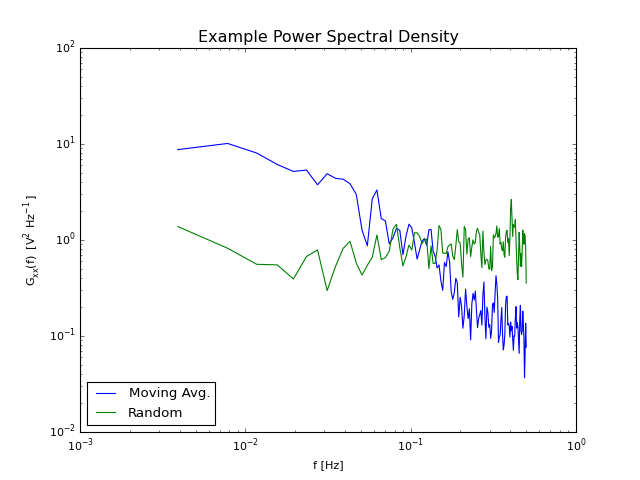

In [21]:
from matplotlib.mlab import psd
p1,f=psd(x1,Fs=1.);  # don't use psd for your homework until you prove it works!
p2,f=psd(x2,Fs=1.);
fig,ax=plt.subplots(1,1)
ax.loglog(f,p1,label='Moving Avg.')
ax.loglog(f,p2,label='Random')
ax.legend(loc=3);ax.set_title('Example Power Spectral Density',fontsize='x-large')
ax.set_xlabel('f [Hz]'); ax.set_ylabel('$G_{xx}(f)\ \ [V^2 Hz^{-1}]$')

The interepretation of the above is that the random process has (almost) equal energy or variance at all frequencies, or scales, while the moving-average has a lot more low-frequency energy than high-frequency.  Recall that we set the variance of these two time series to be equal, and as we will see below in Parseval's theorem, that means the intergal under these two curves is the same, hence they cross in the middle.   

Note, that we almost always plot power spectra on log-log scales. 

### Definition: From Lag Correlation

There are a couple of ways to define a power spectra.  The first relates to the Lag Correlation, $R_{xx}$ just discussed.  If we assume $R_{xx}(\tau)$, $R_{yy}(\tau)$ and $R_{xy}(\tau)$ all exist, and that the lag correlations go to zero for large $\tau$, i.e.

\begin{equation}
    \int_{-\infty}^{\infty} \left| R_{xy}(\tau)  \right| \ \mathrm{d}\tau \lt \infty
\end{equation}

then we define the power spectral density function as:

\begin{align}
    S_{xx}(f) & = \int_{-\infty}^{\infty}  R_{xx}(\tau)\ \mathrm{e}^{-\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
    S_{xy}(f) & = \int_{-\infty}^{\infty}  R_{xy}(\tau)\ \mathrm{e}^{-\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
\end{align}

where $j=\sqrt{-1}$.  The independent variable $f$ is a frequency, and has units of 1/time, in this case cycles-per-second or $\mathrm{Hz}$. So the power spectral density is a tranformation of a signal from time to frequency (or space to wavenumber).

The inverse is:

\begin{align}
    R_{xy}(f) & = \int_{-\infty}^{\infty}  S_{xy}(\tau)\ \mathrm{e}^{+\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
\end{align}

A quick note on units.  If $x$ has units of $\mathrm{V}$ (volts), $R_{xx}$ has units of $\mathrm{V}^2$.  If the lag $\tau$ is in seconds, then $S_{xy}$ has units of $\mathrm{V}^2 \mathrm{s}$.  We often write this as $\mathrm{V}^2\ \mathrm{Hz}^{-1}$,  because of the interpretation of $S_{xx}(f)$ as a variance density in frequency space.  

It is easy to show that the spectral density is symmetric in $f$:

\begin{equation}
    S_{xx}(-f) = S^*_{xx}(f) = S_{xx}(f)
\end{equation}

\begin{equation}
    S_{xy}(-f) = S^*_{xy}(f) = S_{yx}(f)
\end{equation}

where $S^*_{xy}$ is the complex conjugate of $S_{xy}$.  Note that the first equality means that $S_{xx}$ is real, and symmetric about $f=0$.  


**Proof** of  $S_{xy}(-f) = S_{yx}(f)$

This follows simply from the fact that $R_{xy}(\tau)=R_{yx}(-\tau)$, and doing a simple change of variables:

\begin{align}
    S_{xy}(-f) & = \int_{-\infty}^{\infty}  R_{xy}(\tau)\ \mathrm{e}^{+\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
       &  = \int_{-\infty}^{\infty}  R_{yx}(-\tau)\ \mathrm{e}^{+\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
       &  = \int_{-\infty}^{\infty}  R_{yx}(\tau')\ \mathrm{e}^{-\mathrm{j}2\pi f \tau'}\,\mathrm{d}\tau' \\
       &  = S_{yx}(f)       
\end{align}

The other proofs follow in a similar manner.

Because we can say that $S_{xx}(-f)=S_{xx}(f)$ it is redundant to consider both sides of $f$, so we usually just look at the **one-sided-spectrum**:

\begin{aligned}
    G_{xx}(f) & \equiv 2 S_{xx}(f) && \text{for } f>0
\end{aligned}

**Note** that since $G_{xx}(f)$ is real then we can also just use the cosine to calculate it from the real correlation function:

\begin{aligned}
    G_{xx}(f) & = 2\int_{-\infty}^{\infty} R_{xx}(\tau)\cos(2\pi f\tau)\ \mathrm{d}\tau\\
    &= 4\int_{0}^{\infty} R_{xx}(\tau)\cos(2\pi f\tau)\ \mathrm{d}\tau\\
\end{aligned}


### Revisit Motivating Example 

Lets consider the motivating example considred above of two sine waves and some random noise.  We will
 
  1. Compute the lag auto-correlation
  2. Compute the one-sided power spectrum
  
Here we have to digitize the data, so the integrals above are replaced by summations.  There is also the problem that we need the auto lag correlation to go to zero at infinity.  The auto lag correlation of a sine wave is a sine wave, which never goes to zero.  So, here we "taper" the signal and add a lot of zeros so it is uncorrelated at infinity.  

<IPython.core.display.Javascript object>


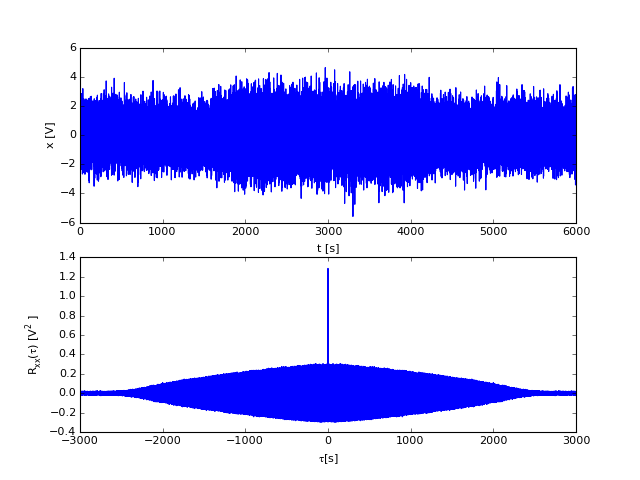

In [148]:
# first sine wave
t = np.arange(0.,3000.,0.1)
A1 = 1.;  om1 = 2.*np.pi/1.;  ph1=0.
x1 = A1*np.cos(om1*t+ph1)
# taper:
nt=10000
x1[:nt/2]=x1[:nt/2]*0.5*(1-np.cos(2.*np.pi*np.arange(nt/2)/(nt-1)))
x1[-nt/2:]=x1[-nt/2:]*0.5*(1-np.cos(2.*np.pi*(nt/2-np.arange(nt/2))/(nt-1)))

# second sine wave
A2 = 0.7;   om2 = 2.*np.pi*0.3;   ph2=0.3
x2 = A2*np.cos(om2*t+ph2)
x2[:nt/2]=x2[:nt/2]*0.5*(1-np.cos(2.*np.pi*np.arange(nt/2)/(nt-1)))
x2[-nt/2:]=x2[-nt/2:]*0.5*(1-np.cos(2.*np.pi*(-np.arange(nt/2)+nt/2)/(nt-1)))
x=x1+x2
# set to zeros at edges
x = np.concatenate((np.zeros(15000),x,np.zeros(15000)))
# Add Noise 
n=1.*np.random.randn(len(x))
x=x+n
# remake t, the time variable.  
t=np.arange(0,6000,0.1)
fig,axs=plt.subplots(2,1,figsize=(8,6))
ax=axs[0]
ax.plot(t,x)
#ax.set_xlim(110,140)
ax.set_xlabel('t [s]'),ax.set_ylabel('x [V]')
# compute the auto-lag correlation:
lags = range(-30000,30000)
Rxx = np.zeros(len(lags))
for num,lag in enumerate(lags):
    if lag>0:
        Rxx[num]= np.mean(x[lag:]*x[:-lag] )
    elif lag<0:
        Rxx[num]= np.mean(x[-lag:]*x[:lag] )
    else:
        Rxx[num]= np.mean(x*x)
    

tau = np.array(lags)*np.median(np.diff(t))
axs[1].plot(tau,Rxx)    
#axs[1].set_xlim(-4.,4.)
axs[1].set_xlabel(r'$\tau [s]$')
axs[1].set_ylabel(r'$R_{xx}(\tau)\ [V^2]$')

The auto-correlation goes to zero at large lags.  We cannot see the sie waves in this plot, but if we zoom in:

<IPython.core.display.Javascript object>


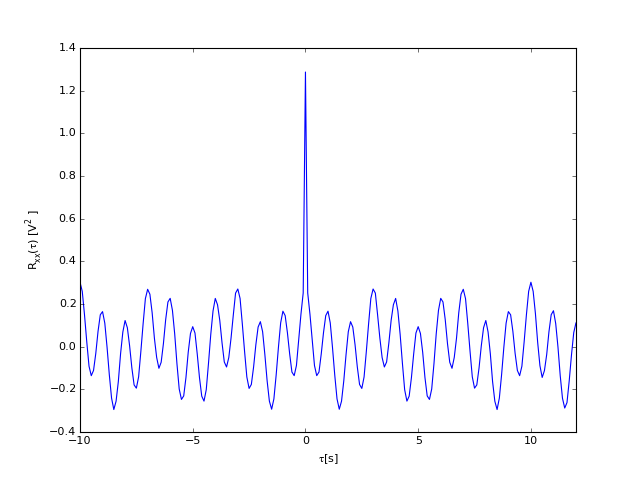

In [150]:
fig,ax=plt.subplots()
ax.plot(tau,(Rxx))
ax.set_xlim(-10.,12.)
ax.set_xlabel(r'$\tau [s]$')
ax.set_ylabel(r'$R_{xx}(\tau)\ [V^2]$')

<IPython.core.display.Javascript object>


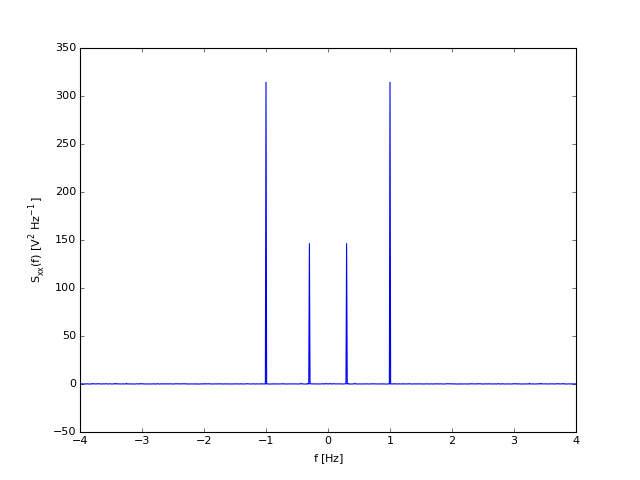

In [152]:
f = np.arange(-4.,4.,0.01)
Sxx =1j*f*0.
dtau = np.median(np.diff(tau))
for num,ff in enumerate(f):
    Sxx[num] = np.sum(Rxx*np.exp(1j*2.*np.pi* tau*ff)*dtau)
fig,ax=plt.subplots()
ax.plot(f,(Sxx))
ax.set_xlabel(r'$f\ [Hz]$')
ax.set_ylabel(r'$S_{xx}(f)\ [V^2 Hz^{-1}]$')

Here the two peaks show up clearly in the power sepctrum.  Note, we usually plot as log-log, but there are some big issues with our spectral *estimate*.   Theoretically, $S_{xx}$ should be real and greater than zero. However, the finite calculation has variability that makes it go below zero occasionally and have a small imaginary component.

Note, however, that the spectrum is (almost) symmeteric about $f=0$, which is as promised.  Just plotting $G_{xx}$:

<IPython.core.display.Javascript object>


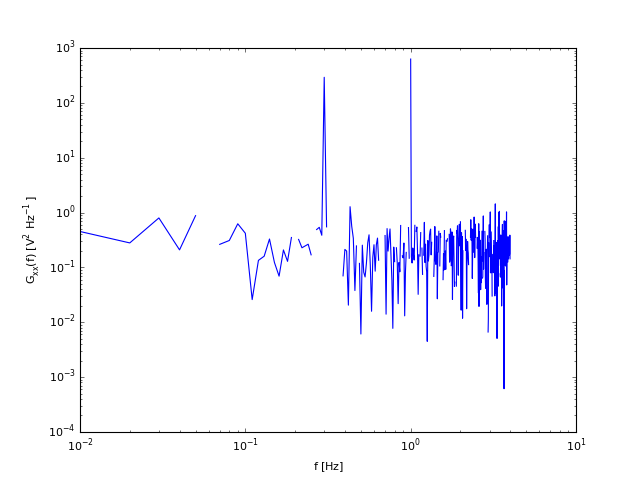

In [154]:
fig,ax=plt.subplots()
ax.loglog(f[f>0],2.*Sxx[f>0])  #note the factor of 2!
ax.set_xlabel(r'$f\ [Hz]$')
ax.set_ylabel(r'$G_{xx}(f)\ [V^2 Hz^{-1}]$')

So, the negative values are a problem, but the two robust peaks show up at $f=3.$ and $f=1 \ \mathrm{Hz}$.

### Relationship between spectral density and variance of a signal

It should be clear then, that 

\begin{equation}
  R_{xx}(0)=\int_0^{\infty} G_{xx}(f)\ \mathrm{d}f
\end{equation}

i.e. the integral of the area under the spectral density curve is $E\left[x^2\right]$, which if $\mu_x=0$ means 

\begin{equation}
  \sigma_x^2=\int_0^{\infty} G_{xx}(f)\ \mathrm{d}f
\end{equation}

Note that this leads to the interpretation that the area under part of the curve between $f$ and $f+\delta f$ is the fraction of variance in that frequency interval.

### Quick note on why we decompose into frequency components

<figure>
<IMG SRC="images/FourierFit.png" WIDTH=320 ALIGN="right" STYLE="padding-left:20px" ALT="Example of Fourier fit">
</figure>

Amongst all the math, we can lose sight of why we want to look at $G_{xx}(f)$.  In a linear system, the variance at each $f$ represents the power in a wave at that frequency, hence the name **power spectrum**.  Since waves are such a fundamental natural phenomena, sine waves are a natural way to decompose many signals.

We will see later when we come to finite discrete time series that an appropriately designed set of sines and cosines that fit in the finite time interval comprise a basis of all real functions on that interval.  However the idea is sketched to the right.  The first fit is to the lowest frequency and explains a good proportion of the variance.  The second fit is to the next higher frequency and improves the fit, etc.  For this signal, the sum of the first six fits does quite well at explaining the signal.  

The amplitude squared of these fits are the discrete analogue of $G_{xx}(f)$, and so $G_{xx}(f)$ can be thought of as describing the amplitude of waves that make up the time series $x(t)$.  

### Finite Fourier Transform

We usually only have a finite time series, $x(t)$, $0\leq t \leq T$, and as such the lag correlation is formally undefined.  Regardless, we can define a power spectrum by taking the **Fourier Transform** of our time series.  So for the **cross spectrum**:

\begin{equation}
    S_{xy}(f,T) = \frac{1}{T} X^*(f,T) Y(f,T)
\end{equation}

where

\begin{align}
    X(f,T) & = \int_0^T x(t)\,\mathrm{e}^{-j2\pi ft}\ \mathrm{d}t\\
    Y(f,T) & = \int_0^T y(t)\,\mathrm{e}^{-j2\pi ft}\ \mathrm{d}t\\
\end{align}

Of course the spectrum depends on $T$.  We would like to know how it relates to the true spectrum of the processes, $S_{xy}(f)$, for $x(t)$ and $y(t)$ for all $T$.

It is tempting to define

\begin{equation}
    S_{xy}(f) = \lim_{T\to\infty} S_{xy}(f,T)
\end{equation}

however, this is an error given that increasing $T$ does *not* improve the estimate of $S_{xy}(f)$ at any given $f$.  

Instead, we need to recall that $S_{xy}(f,T)$ is a random variable.  Then we can prove that:
\begin{equation}
     S_{x,y}(f)= \lim_{T\to\infty} E\left[ S_{xy}(f,T) \right]
\end{equation}

**Proof** First recall that 

\begin{equation}
     S_{x,y}(f)= \int_{-\infty}^{\infty} R_{xy}(\tau) \mathrm{e}^{-j2\pi f \tau} \mathrm{d}\tau
\end{equation}

Now from the definition of $S_{xy}(f,T)$:

\begin{align}
    S_{xy}(f,T)&=\frac{1}{T}\int_0^T \int_0^T  x(\alpha)\,y(\beta)\,\mathrm{e}^{+j2\pi f\alpha}\mathrm{e}^{-j2\pi f\beta}\ \mathrm{d}\alpha\,\mathrm{d}\beta\\
\end{align}

if we choose $\tau=\beta-\alpha$:

\begin{align}
    S_{xy}(f,T)&=\frac{1}{T}\int_{-T}^{0} \int_{-\tau}^T  x(\alpha)\,y(\tau+\alpha)\,\mathrm{e}^{-j2\pi f\tau}\ \mathrm{d}\alpha\,\mathrm{d}\tau\\
    &+\frac{1}{T}\int_{0}^{T} \int_{0}^{T-\tau}  x(\alpha)\,y(\tau+\alpha)\,\mathrm{e}^{-j2\pi f\tau}\ \mathrm{d}\alpha\,\mathrm{d}\tau\\
     E\left[S_{xy}(f,T)\right]&=\frac{1}{T}\int_{-T}^{0} \int_{-\tau}^T  R_{xy}(\tau)\,\mathrm{e}^{-j2\pi f\tau}\ \mathrm{d}\alpha\,\mathrm{d}\tau\\
    &+\frac{1}{T}\int_{0}^{T} \int_{0}^{T-\tau}  R_{xy}(\tau)\,\mathrm{e}^{-j2\pi f\tau}\ \mathrm{d}\alpha\,\mathrm{d}\tau\\
    E\left[S_{xy}(f,T)\right]&=\int_{-T}^{T}   \frac{T-|\tau|}{T} R_{xy}(\tau)\,\mathrm{e}^{-j2\pi f\tau}\ \mathrm{d}\tau\\
\end{align}

Taking the limit proves that expected value of the finite power spectrum approaches that of the full spectrum as $T\to\infty$:

\begin{align}
    \lim_{T\to\infty} E\left[S_{xy}(f,T)\right]&=\int_{-\infty}^{\infty}   R_{xy}(\tau)\,\mathrm{e}^{-j2\pi f\tau}\ \mathrm{d}\tau = S_{xy}(f)\\
\end{align}

It is worth keeping in mind that the finite spectrum $S_{xy}(f,T)$ is a statistical estimate of $S_{xy}(f)$, and thus has a distribution associated with each frequency $f$, and therefore confidence intervals.  We will cover these below in the discrete power spectrum discussion.

Estimating $X(f)$ from the example above and then computing the power spectrum yields a positive definite quantity by definition:

<IPython.core.display.Javascript object>


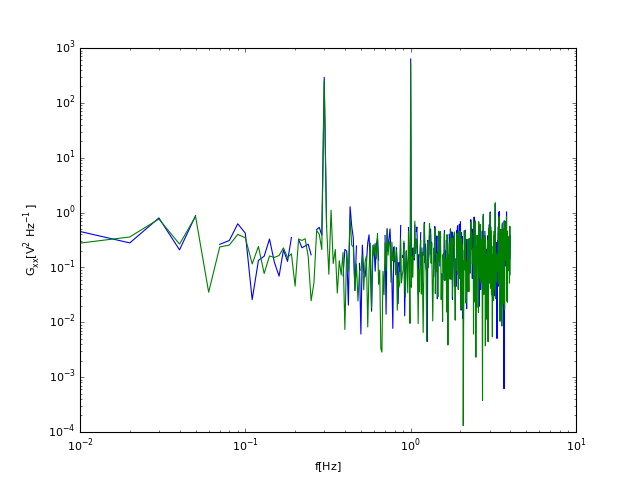

In [155]:
f = np.arange(-4.,4.,0.01)
X =1j*f*0.
T = t[-1]-t[0] # get the sampling interval
dt = np.median(np.diff(t))
for num,ff in enumerate(f):
    X[num] = np.sum(x*np.exp(-1j*2.*np.pi*t*ff)*dt)
Sxxnew = X*np.conj(X)/T
fig,ax=plt.subplots()
ax.loglog(f[f>0],2.*Sxx[f>0])
ax.loglog(f[f>0],2.*Sxxnew[f>0])
ax.set_xlabel(r'$f [Hz]$')
ax.set_ylabel(r'$G_{xx} [V^2 Hz^{-1}]$')

This new estimate is substantially better than the one using $R_{xx}$ for this finite and digital time series because it is at least always positive and real.

### Parseval's Theorem

Parseval's Theorem basically relates the variance of the process to the spectra, as above:

\begin{equation}
    \int_{-\infty}^{\infty} x(t)y(t)\ \mathrm{d}t = \int_{-\infty}^{\infty} X^*(f)Y(f)\ \mathrm{d}f
\end{equation}

The proof of this is relatively easy application of the inverse Fourier transform.  For the special case of $y(t)=x(t)$ we recover the idea that the variance of the process is the integral of the power spectrum:

\begin{equation}
    \int_{-\infty}^{\infty} x^2(t)\ \mathrm{d}t = \int_{-\infty}^{\infty} |X(f)|^2 \ \mathrm{d}f
\end{equation}


### Interpreting the Fourier Transform

Recall that the *Fourier Transform* of $x(t)$ is 

\begin{align}
    X(f,T) & = \int_0^T x(t)\,\mathrm{e}^{-j2\pi ft}\ \mathrm{d}t\\
\end{align}

Note that $X(f,T)$ is a complex number and can be written a few different ways:

\begin{align}
    X(f,T) &= X_R(f,T)+jX_I(f,T)\\
        &= |X(f,T)|\,e^{j\phi(f,T)}
\end{align}

where $\phi(f,T)$ is the **phase** of the Fourier component, and is given by 

\begin{align}
    \tan\left(\phi(f,T)\right)=\frac{X_I(f,T)}{X_R(f,T)}
\end{align}

This has the physical interpretation that this frequency component of the signal $x(t)$ is a cosine with amplitude $|X(f,T)|$ and phase relative to $t=0$ of $\phi(f,T)$.  


### Summary of spectral density

The preceding is a bit theoretical, but the basic ideas should be clear:  

  1. The spectrum is related to the lag correlation by taking a Fourier transform of the lag correlation
  2. The spectrum can also be estimated directly from a finite signal by taking their Fourier transforms and multplying the result.
  2. The expected value finite spectrum derived from the signals approaches the formal spectrum as the sampling period $T$ goes to infinity.
  3. The variance of the signal is equal to the integral of the power spectrum.  